Import torch stuff, matplotlib, tqdm, and the model.

In [52]:
import torch as pt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

import matplotlib.pyplot as plt
from tqdm import tqdm

import model as mm

Make simplest dataset to test if memory even works (ODR).

In [55]:
class ODRDataset(Dataset):
    def __init__(self, directions=4, min_wait=5, max_wait=10):
        if min_wait >= max_wait:
            raise Exception("Min wait must be less than max wait.")

        self.directions = directions
        self.min_wait = min_wait
        self.max_wait = max_wait

    def __len__(self):
        return self.directions * (self.max_wait - self.min_wait)

    def __getitem__(self, ind):
        if ind >= len(self):
            raise Exception("Index out of range.")
        
        wait = int(ind / self.directions)
        direction = ind % self.directions

        x = pt.zeros(self.max_wait + 2, self.directions + 1, dtype=pt.float32)
        x[0][direction] = 1
        x[wait + 1][-1] = 1
        
        labels = pt.full((self.max_wait + 2,), self.directions, dtype=pt.int64)
        labels[wait + 1] = direction

        return x, labels

Test dataset out for something simple.

In [ ]:
dataset = ODRDataset(3, 0, 2)
dataloader = DataLoader(dataset)
print(f"{len(dataset)} elements")
for x, labels in dataloader:
    print(f"x:\n{x}\nlabel:\n{labels}\n")

6 elements
x:
tensor([[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], dtype=torch.float16)
label:
tensor([[3, 0, 3, 3]])

x:
tensor([[[0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], dtype=torch.float16)
label:
tensor([[3, 1, 3, 3]])

x:
tensor([[[0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], dtype=torch.float16)
label:
tensor([[3, 2, 3, 3]])

x:
tensor([[[1., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 0.]]], dtype=torch.float16)
label:
tensor([[3, 3, 0, 3]])

x:
tensor([[[0., 1., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 0.]]], dtype=torch.float16)
label:
tensor([[3, 3, 1, 3]])

x:
tensor([[[0., 0., 1., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 0.]]], dtype=torch.float16)
label:
tensor([[3, 3, 2, 3]])


Make a training dataloader. Don't bother splitting dataset because if the model has nonfunctioning memory then it can't even overfit to begin with. Four directions and wait time in range(9). Also make the model, just 1 block, and make the criterion and optimizer.

In [87]:
dataset = ODRDataset(4, 1, 10)
dataloader = DataLoader(dataset, batch_size=8)
model = mm.MoPeAModel(5, 16, 5, 16, depth=1)
raw_criterion = nn.CrossEntropyLoss()
def criterion(outputs, labels):
    outputs = outputs.view(-1, outputs.shape[-1])
    labels = labels.view(-1)
    return raw_criterion(outputs, labels)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=20,
)

print(f"dataset length: {len(dataset)}\nnumber of batches: {len(dataloader)}")

dataset length: 36
number of batches: 5


Train the model now on the dataset for 100 epochs and then plot the loss graph.

100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s, loss=0.1817, lr=1e-8] 


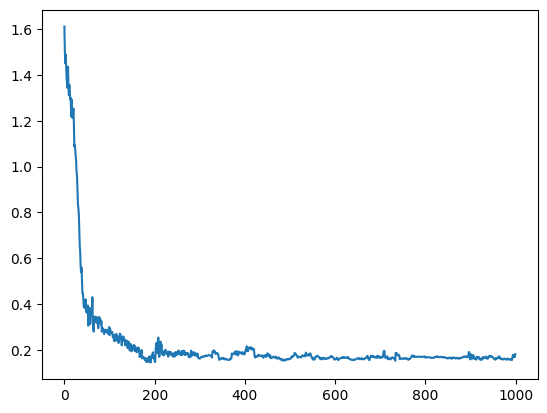

In [88]:
model.train()
losses = []
pbar = tqdm(range(1000))
for epoch in pbar:
    total_loss = 0
    for x, labels in dataloader:
        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    current_lr = optimizer.param_groups[0]['lr']
    pbar.set_postfix(loss=f"{avg_loss:.4f}", lr=current_lr)

    scheduler.step(avg_loss)
model.eval()
print()

plt.plot(losses)
plt.show()

Since the model is able to learn the ODR task it means the model has some sort of memory capabilities, because if it didn't then it shouldn't have any information from the past states.